In [57]:
import numpy as np
import pandas as pd
import requests
import tqdm
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

def check_missing(df):
    per_missing = df.isnull().mean()
    missing_df = pd.DataFrame({'col': df.columns, 'per_missing': per_missing})
    missing_df = missing_df.sort_values('per_missing',ascending=False).reset_index(drop=True)
    missing_df['col'] = pd.Categorical(missing_df.col, categories=missing_df.col, ordered=True)
    return missing_df

In [29]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
from plotnine import *
from mizani import *
theme_set(theme_minimal(14, 'TH Sarabun New'))

In [11]:
# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

## Download Data

We downloaded all projects on [thaime](http://nscr.nesdb.go.th/thaime-project/) as of 2020-06-12.

In [93]:
# #scrape and save
# chunk = 11
# rows=[]
# for chunk in tqdm.tqdm_notebook(range(12)):
#     url = f'http://nscr.nesdb.go.th/wp-admin/admin-ajax.php?action=wp_ajax_ninja_tables_public_action&table_id=11868&target_action=get-all-data&default_sorting=old_first&skip_rows=0&limit_rows=0&chunk_number={chunk}'
#     with requests.get(url) as r:
#         content = eval(r.content)
#         rows+=[i['value'] for i in content]
# thaime = pd.DataFrame(rows).iloc[:-3,:]
# thaime.columns = ['id','plan_nb','project_name','budget','unit','ministry','province','created_date','details_url']
# thaime.to_csv('data/thaime_raw.csv',index=False)

## Clean Data

In [325]:
thaime = pd.read_csv('data/thaime_raw.csv')
thaime.shape

(33716, 9)

In [326]:
thaime.tail()

,id,plan_nb,project_name,budget,unit,ministry,province,created_date,details_url
33711,261826,3.2,โครงการ พัฒนาป่าไม้ สร้างงาน สร้างรายได้ เพื่อ...,"607,480,000",กรมป่าไม้,กระทรวงทรัพยากรธรรมชาติและสิ่งแวดล้อม,ทุกจังหวัด,5\/6\/2563,"<a href=""https:\/\/drive.google.com\/file\/d\/..."
33712,261827,3.2,โครงการ 1 ตำบล 1 กลุ่มเกษตรทฤษฎีใหม่,"14,315,832,480",สำนักงานปลัดกระทรวงเกษตรและสหกรณ์ และกรมชลประทาน,กระทรวงเกษตรและสหกรณ์,ทุกจังหวัด,5\/6\/2563,"<a href=""https:\/\/drive.google.com\/file\/d\/..."
33713,261828,3.2,โครงการเฝ้าระวังสร้างแนวกันไฟสร้างรายได้ชุมชน,"246,699,000",กรมอุทยานแห่งชาติ สัตว ป่ า และพันธุ์ พืช,กระทรวงทรัพยากรธรรมชาติและสิ่งแวดล้อม,ชุมชนโดยรอบพื้นที่ป่าอนุรักษ์,5\/6\/2563,"<a href=""https:\/\/drive.google.com\/file\/d\/..."
33714,261829,3.2,โครงการพัฒนาพื้นที่ต้นแบบการพัฒนาคุณภาพชีวิตตา...,"5,672,001,800",กรมการพัฒนาชุมชน,กระทรวงมหาดไทย,ทุกจังหวัด,5\/6\/2563,"<a href=""https:\/\/drive.google.com\/file\/d\/..."
33715,261830,3.2,ยกระดับเศรษฐกิจและสังคมรายตำบลแบบบูรณาการ (1 ต...,"13,500,000,000",สำนักปลัดกระทรวงการอุดมศึกษา วิทยาศาสตร์ วิจัย...,กระทรวงการอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,ทุกจังหวัด,5\/6\/2563,"<a href=""https:\/\/drive.google.com\/file\/d\/..."


In [327]:
def str_to_float(x):
    try:
        return float(x.replace(',',''))
    except:
        return None

#convert to numbers
thaime['budget'] = thaime.budget.map(str_to_float)

In [328]:
#remove text artifacts
for c in ['project_name','unit','ministry','province','created_date','details_url']:
    #remove \
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\\',''))
    #replace \n with /
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\n','/'))
    #replace nan with None
    thaime[c] = thaime[c].map(lambda x: None if str(x) in ['nan','-','None'] else x)

In [329]:
#created date
def split_date(x):
    try:
        splitted = x.split('/')
        return f'{int(splitted[2])-543}-{splitted[1].zfill(2)}-{splitted[0].zfill(2)}'
    except:
        return x
thaime['created_date'] = thaime.created_date.map(split_date)

In [380]:
#you can't really clean province
thaime.province.value_counts().reset_index().sort_values('province').tail(10)

,index,province
9,แม่ฮ่องสอน,870
8,เชียงใหม่,1039
7,สุโขทัย,1106
6,สกลนคร,1127
5,กำแพงเพชร,1146
4,น่าน,1196
3,ยโสธร,1265
2,เพชรบูรณ์,1630
1,มุกดาหาร,1682
0,กาฬสินธุ์,2070


In [331]:
#extract details url
def get_details_url(x):
    try:
        return BeautifulSoup(x).find('a').get('href')
    except:
        return x
thaime['details_url'] = thaime.details_url.map(get_details_url)

In [332]:
#handle ministries
ministries = pd.DataFrame(thaime.ministry.map(lambda x: x.replace('กระทรวง','') if x is not None else x)\
                          .value_counts()).reset_index()
ministries.columns = ['ministry','cnt']
ministries.head()

,ministry,cnt
0,มหาดไทย,30807
1,เกษตรและสหกรณ์,739
2,คมนาคม,676
3,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,329
4,การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,295


In [333]:
#create dictionary of duplicate ministry names
ministry_dict = {}
for m in ministries.ministry:
    i=0
    for k in ministry_dict.keys():
        if fuzz.ratio(m,k)>90:
            i+=1
            ministry_dict[k]+=f'|{m}'
    if i==0: ministry_dict[m]=m

In [336]:
#replace with corrected name
correct_dict = {}
for k,v in ministry_dict.items():
    vs = v.split('|')
    for v_ in vs:
        correct_dict[v_] = k

thaime['ministry'] = thaime.ministry.map(lambda x: x.replace('กระทรวง','') if x is not None else x)\
    .map(lambda x: correct_dict[x] if x is not None else x)
thaime.ministry.value_counts().head()

มหาดไทย                                      30807
เกษตรและสหกรณ์                                 742
คมนาคม                                         676
ทรัพยากรธรรมชาติและสิ่งแวดล้อม                 350
การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม      334
Name: ministry, dtype: int64

In [368]:
ministry_df = pd.DataFrame.from_dict(ministry_dict,orient='index').reset_index()
ministry_df.columns = ['key','val']
ministry_df['nb_val'] = ministry_df.val.map(lambda x: len(x.split('|')))
ministry_df = ministry_df.sort_values('nb_val',ascending=False).reset_index(drop=True)
for i,row in ministry_df.head(5).iterrows():
    print(f"Ministry name: {row['key']}")
    print(f"Variations: {row['val']}")
    print('-------------------------------------')

Ministry name: ทรัพยากรธรรมชาติและสิ่งแวดล้อม
Variations: ทรัพยากรธรรมชาติและสิ่งแวดล้อม|ทรัพยากรธรรมชาติและสิ่งแวดล?อม|ทรัพยากร ธรรมชาติและสิ่งแวดล้อม|ทัพยากรธรรมชาติละสิ่งแวดล้อม
-------------------------------------
Ministry name: การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม
Variations: การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม|การอุดมศึกษา วิทยาศาสตร์ วิจัย และนวัตกรรม|อุดมศึกษา วิทยาศาสตร์ วิจัย และนวัตกรรม|การอุดมศึกษา วิทยาศาสตร์วิจัย และนวัตกรรม
-------------------------------------
Ministry name: การท่องเที่ยวและกีฬา
Variations: การท่องเที่ยวและกีฬา|การท่่องเที่ยวและกีฬา|การท่องเที่ี่ยวและกีฬา|ท่องเที่ยวและกีฬา
-------------------------------------
Ministry name: เกษตรและสหกรณ์
Variations: เกษตรและสหกรณ์|เกษตและสหกรณ์
-------------------------------------
Ministry name: วัฒนธรรม
Variations: วัฒนธรรม|วัฒธรรม
-------------------------------------


In [337]:
#handle units
units = pd.DataFrame(thaime.unit.map(lambda x: x if x is not None else x)\
                          .value_counts()).reset_index()
units.columns = ['unit','cnt']
units.head()

,unit,cnt
0,กรมส่งเสริมการปกครองท้องถิ่น,20258
1,กรมส่งเสริมการปกครองส่วนท้องถิ่น,4012
2,จังหวัดสุโขทัย,603
3,จังหวัดพิจิตร,412
4,จังหวัดยะลา,346


In [338]:
#create dictionary of duplicate unit names
unit_dict = {}
for m in units.unit:
    i=0
    for k in unit_dict.keys():
        if fuzz.ratio(m,k)>90:
            i+=1
            unit_dict[k]+=f'|{m}'
    if i==0: unit_dict[m]=m

In [340]:
#replace with corrected name
correct_dict = {}
for k,v in unit_dict.items():
    vs = v.split('|')
    for v_ in vs:
        correct_dict[v_] = k

thaime['unit'] = thaime.unit.map(lambda x: correct_dict[x] if x is not None else x)
thaime.unit.value_counts().head()

กรมส่งเสริมการปกครองท้องถิ่น    24270
จังหวัดสุโขทัย                    603
จังหวัดพิจิตร                     412
จังหวัดยะลา                       346
กรมชลประทาน                       344
Name: unit, dtype: int64

In [369]:
unit_df = pd.DataFrame.from_dict(unit_dict,orient='index').reset_index()
unit_df.columns = ['key','val']
unit_df['nb_val'] = unit_df.val.map(lambda x: len(x.split('|')))
unit_df = unit_df.sort_values('nb_val',ascending=False).reset_index(drop=True)
for i,row in unit_df.head(5).iterrows():
    print(f"Unit name: {row['key']}")
    print(f"Variations: {row['val']}")
    print('-------------------------------------')

Unit name: กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช
Variations: กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช|กรมอุทยานแห่งชาติ สัตว์ป่าและพันธุ์พืช|กรมอุทยานแห่งชาติสัตว์ป่า และพันธุ์พืช|กรมอุทยานแห่งชาติ สัตวป่า และพันธุ์พืช|กรมอุทยานแห่งชาติ /สัตว์ป่า และพันธุ์พืช|กรมอุทยานแห่งชาติสัตว์ป่าและพันธุ์พืช
-------------------------------------
Unit name: องค์การบริหารส่วนจังหวัดตรัง
Variations: องค์การบริหารส่วนจังหวัดตรัง|องค์การบริหารส่วนจังหวัดระยอง|องค์การบริหารส่วนจังหวัดตราด|องค์การบริหารส่วนจังหวัดพังงา|องค์การบริหารส่วนจังหวัดระนอง
-------------------------------------
Unit name: องค์การบริหารส่วนจังหวัดจันทบุรี
Variations: องค์การบริหารส่วนจังหวัดจันทบุรี|องค์การบริหารส่วนจังหวัดกาญจนบุรี|องค์การบริหารส่วนจังหวัดปราจีนบุรี|องค์การบริหารส่วนจังหวัดนนทบุรี
-------------------------------------
Unit name: องค์การสวนสัตว์ ในพระบรมราชูปถัมภ์
Variations: องค์การสวนสัตว์ ในพระบรมราชูปถัมภ์|องค์การสวนสัตว์ในพระบรมราชูปถัมภ์|องค์การสวนสัตว์ ในพระ บรมราชูปถัมภ์
-------------------------------

In [341]:
# thaime.to_csv('data/thaimaimee.csv',index=False)

## Explore

In [11]:
thaime = pd.read_csv('data/thaimaimee.csv')
thaime['budget_g'] = thaime.budget/1e9
thaime.head()

,id,plan_nb,project_name,budget,unit,ministry,province,created_date,details_url,budget_g
0,228115,3.1,โครงการพื้นที่ท่องที่ยวปลอดภัยส าหรับนักท่องเท...,10000000.0,กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,NaN,2020-05-06,https://drive.google.com/file/d/1bOhpEJIvrTCc9...,0.010000
1,228116,3.1,พัฒนาระบบโครงสร้างพื้นฐานด้านการท่องเที่ยวเพื่...,24046400.0,องค์การสวนพฤกษศาสตร์,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,NaN,2020-05-06,https://drive.google.com/file/d/1_6PI027oKv9z5...,0.024046
2,228117,3.1,การแปลงเครื่องจักรเป็นทุนโดยการบำรุงรักษาเครื่...,40000000.0,กรมโรงงานอุตสาหกรรม,อุตสาหกรรม,NaN,2020-05-06,https://drive.google.com/file/d/1nfaJkK6XXR3to...,0.040000
3,228118,3.1,การแปลงเครื่องจักรเป็นทุนโดยการบำรุงรักษาเครื่...,40000000.0,กรมโรงงานอุตสาหกรรม,อุตสาหกรรม,NaN,2020-05-06,https://drive.google.com/file/d/1E0nLPJ4OrcexT...,0.040000
4,228119,3.1,"โครงการกำหนดแนวทางการออกแบบ ""เมืองท่องเที่ยว"" ...",50000000.0,กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,NaN,2020-05-06,https://drive.google.com/file/d/1hA9MvOTkoRagM...,0.050000


### Missing Data

In [12]:
#some missing data but not too many
check_missing(thaime)

,col,per_missing
0,details_url,0.250059
1,province,0.000623
2,project_name,0.000356
3,ministry,0.000297
4,budget,0.000119
5,budget_g,0.000119
6,created_date,0.000089
7,unit,0.000059
8,id,0.000000
9,plan_nb,0.000000


### Budget Breakdown by Ministry

In [39]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<3 else row['ministry'],1)
bbm2 = bbm.groupby('ministry_').budget_g.sum().reset_index().sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm2['ministry_'] = pd.Categorical(bbm2.ministry_, categories=bbm2.ministry_,ordered=True)
bbm2.head()

,ministry_,budget_g
0,มหาดไทย,234.981211
1,สำนักนายกรัฐมนตรี,196.326926
2,เกษตรและสหกรณ์,162.408942
3,การคลัง,55.000200
4,สำนักงานกองทุนหมู่บ้านและชุมชนเมืองแห่งชาติ,40.000000


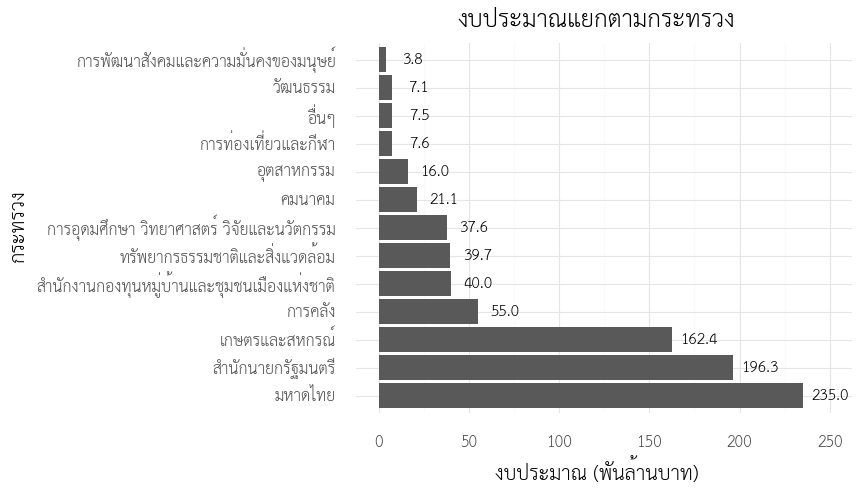

<ggplot: (8787244149540)>

In [42]:
g = (ggplot(bbm2, aes(x='ministry_',y='budget_g')) + geom_col() +
     xlab('กระทรวง') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='ministry_',y='budget_g+15',label='round(budget_g,1)')) +
     coord_flip() + ggtitle('งบประมาณแยกตามกระทรวง'))
g

In [44]:
# bbm['thailand'] = 'thailand'
# fig = px.treemap(bbm, path=['thailand','ministry'], 
#                  values='budget_g',
#                   color='budget_g',
#                   color_continuous_scale='RdBu',
#                   color_continuous_midpoint=bbm.budget_g.quantile(0.95))
# fig.update_layout(uniformtext=dict(minsize=20, mode=False))
# fig.show()

## Number of Projects by Ministry

In [48]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.count()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<30000 else row['ministry'],1)
bbm2 = bbm.groupby('ministry_').budget_g.sum().reset_index().sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm2['ministry_'] = pd.Categorical(bbm2.ministry_, categories=bbm2.ministry_,ordered=True)
bbm2.head()

,ministry_,budget_g
0,มหาดไทย,30805
1,อื่นๆ,2897


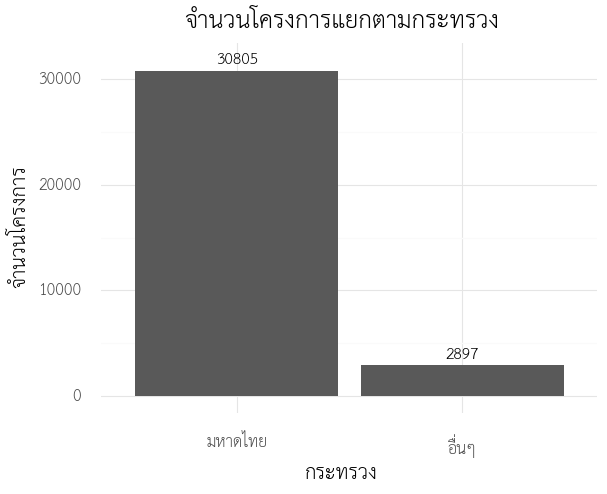

<ggplot: (8787237544561)>

In [52]:
g = (ggplot(bbm2, aes(x='ministry_',y='budget_g')) + geom_col() +
     xlab('กระทรวง') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='ministry_',y='budget_g+1000',label='round(budget_g,1)')) +
     ggtitle('จำนวนโครงการแยกตามกระทรวง'))
g

### Top Projects

In [279]:
bbm = pd.DataFrame(thaime.groupby(['project_name','ministry']).budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True).head(10)
bbm

,project_name,ministry,budget_g
0,โครงการพลิกฟื้นธุรกิจ SME ที่เป็น NPL ให้กลับมาดำเนินธุรกิจได้,สำนักนายกรัฐมนตรี,100.000000
1,โครงการเศรษฐกิจพอเพียงสร้างไทย,การคลัง,55.000000
2,โครงการฟื้นฟูศักยภาพการดำเนินธุรกิจสำหรับ SME ที่ไม่สามารถเข้าถึงแหล่งเงินทุน,สำนักนายกรัฐมนตรี,50.000000
3,โครงการพัฒนาแหล่งน้ำ บริหารจัดการน้ำ และเพิ่มพื้นที่ชลประทาน,เกษตรและสหกรณ์,42.235954
4,โครงการยกระดับเศรษฐกิจชุมชนด้วยการสร้างงาน สร้างอาชีพ และสร้างรายได้ เพื่อบรรเทาผลกระทบทางเศรษฐกิจจากการระบาดของโรคติดเชื้อไวรัสโคโรนา 2019,สำนักงานกองทุนหมู่บ้านและชุมชนเมืองแห่งชาติ,40.000000
5,ยกระดับเศรษฐกิจและสังคมรายตำบลแบบบูรณาการ (1 ตำบล 1 มหาวิทยาลัย),การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,27.000000
6,โครงการไทยเที่ยวไทยไป EEC,สำนักนายกรัฐมนตรี,26.202134
7,โครงการสร้างงาน สร้างรายได้ : หมู่บ้าน/ชุมชนเข้มแข็ง สู้ภัยโควิค-19,มหาดไทย,24.092400
8,โครงการยกระดับแปลงใหญ่ด้วยเกษตรสมัยใหม่และเชื่อมโยงตลาด,เกษตรและสหกรณ์,20.400000
9,โครงการ 1 หมู่บ้าน 1 จุดเรียนรู้ตามแนวทางเกษตรทฤษฎีใหม่,เกษตรและสหกรณ์,19.387365


### Project Size Distribution

In [91]:
thaime['digits'] = thaime.budget.map(lambda x: len(str(round(x))) if x==x else x)
dg = thaime.groupby('digits').project_name.count().reset_index()
dg

,digits,project_name
0,4.0,1
1,5.0,383
2,6.0,15474
3,7.0,13637
4,8.0,3729
5,9.0,419
6,10.0,42
7,11.0,14
8,12.0,1


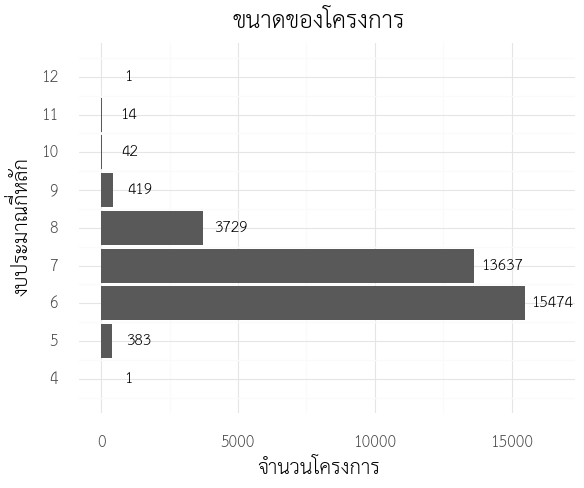

<ggplot: (-9223363249618588114)>

In [100]:
g = (ggplot(dg, aes(x='digits',y='project_name')) + geom_col() +
     xlab('งบประมาณกี่หลัก') + ylab('จำนวนโครงการ') +
     scale_x_continuous(breaks=[i for i in range(13)])+
     geom_text(aes(x='digits',y='project_name+1000',label='round(project_name,1)')) +
     coord_flip() + ggtitle('ขนาดของโครงการ'))
g

### Project Size by Ministry

In [104]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<3 else row['ministry'],1)
top_ministries = list(bbm.ministry_[:12])
top_ministries

['มหาดไทย',
 'สำนักนายกรัฐมนตรี',
 'เกษตรและสหกรณ์',
 'การคลัง',
 'สำนักงานกองทุนหมู่บ้านและชุมชนเมืองแห่งชาติ',
 'ทรัพยากรธรรมชาติและสิ่งแวดล้อม',
 'การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม',
 'คมนาคม',
 'อุตสาหกรรม',
 'การท่องเที่ยวและกีฬา',
 'วัฒนธรรม',
 'การพัฒนาสังคมและความมั่นคงของมนุษย์']

In [108]:
thaime2 = thaime.copy()
thaime2['ministry'] = thaime2.ministry.map(lambda x: 'อื่นๆ' if x not in top_ministries else x)

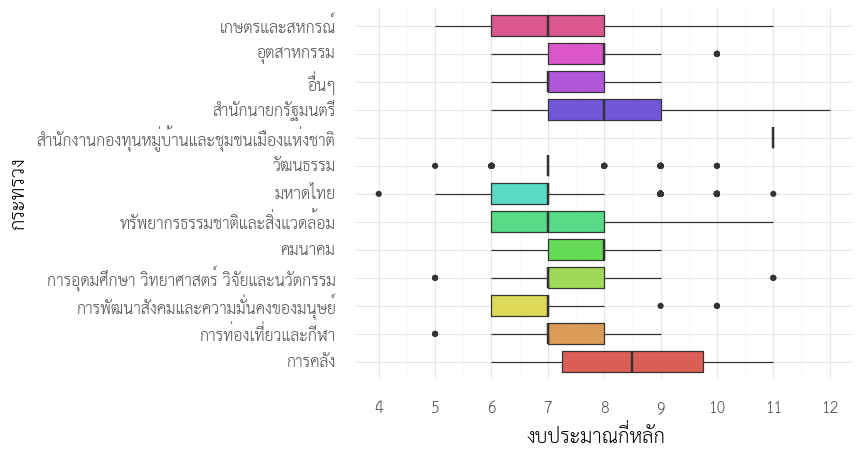

<ggplot: (8787236570958)>

In [118]:
g = (ggplot(thaime2, aes(x='ministry',y='digits',fill='ministry')) + geom_boxplot() +
    theme(legend_position='none') + xlab('กระทรวง') + ylab('งบประมาณกี่หลัก') +
    scale_y_continuous(breaks=[i for i in range(13)])+
    coord_flip())
g

### Project Name Word Cloud

In [184]:
import pythainlp
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [198]:
texts = []
for i in range(thaime.shape[0]):
    texts+=[i for i in word_tokenize(thaime.project_name[i], keep_whitespace=False) if len(i)>2]
text = ' '.join(texts)
text[:100]

'โครงการ พื้นที่ ท่อง ที่ ปลอดภัย หรับ นักท่องเที่ยว Safety Zone พัฒนา ระบบ โครงสร้างพื้นฐาน ด้าน การ'

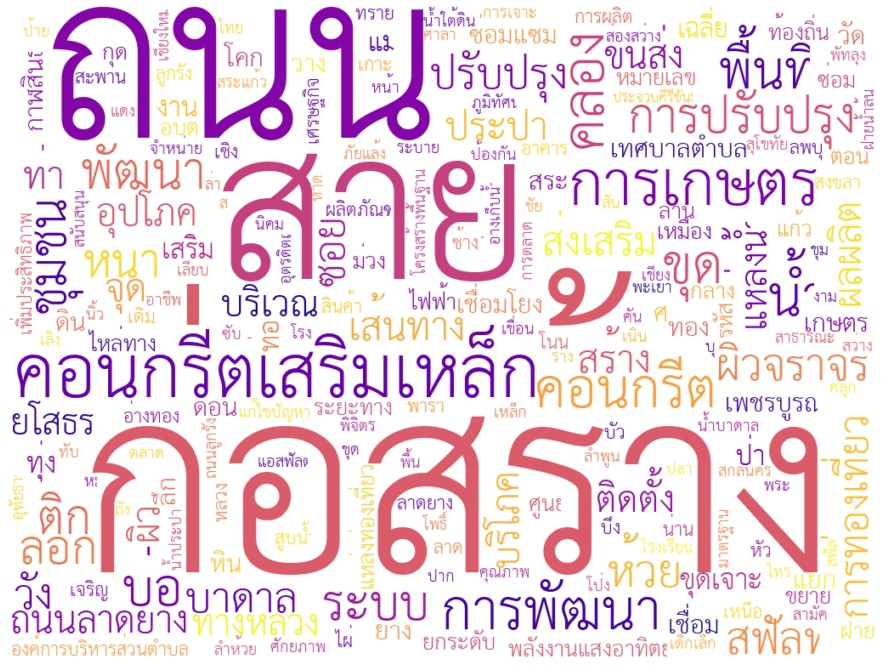

In [200]:
wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      stopwords=list(pythainlp.corpus.common.thai_stopwords()) + \
                          ['โครงการ','โครง',
                           #units
                          'เมตร','ตารางเมตร','ลบ','ตร','กม',
                           #area
                          'จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง',
                           'หมู่บ้าน','หนอง',
                           #size
                           'ขนาด','จำนวน','ปริมาณ']
                      ).generate(text)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### Projects with Specific Keywords: Constructions, Roads and Canels

In [237]:
constructions = ['ก่อสร้าง','คอนกรีต']
roads = ['ถนน','ทางหลวง','อัสฟัล','ผิวจราจร']
canels = ['คลอง','ขุดลอก']

thaime['constructions'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in constructions]) else 'ไม่ใช่')
thaime['roads'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in roads]) else 'ไม่ใช่')
thaime['canels'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in canels]) else 'ไม่ใช่')

In [258]:
bbm = pd.DataFrame(thaime.groupby('constructions').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,constructions,sum,len
0,ไม่ใช่,753.042929,18433.0
1,ใช่,76.319490,15283.0


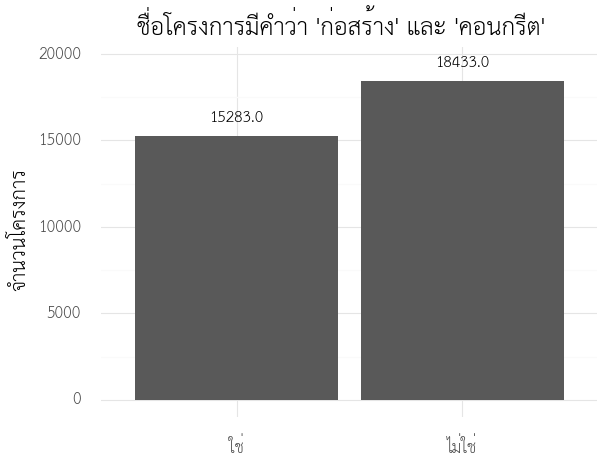

<ggplot: (8787229487592)>

In [259]:
g = (ggplot(bbm, aes(x='constructions',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='constructions',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ก่อสร้าง' และ 'คอนกรีต'"))
g

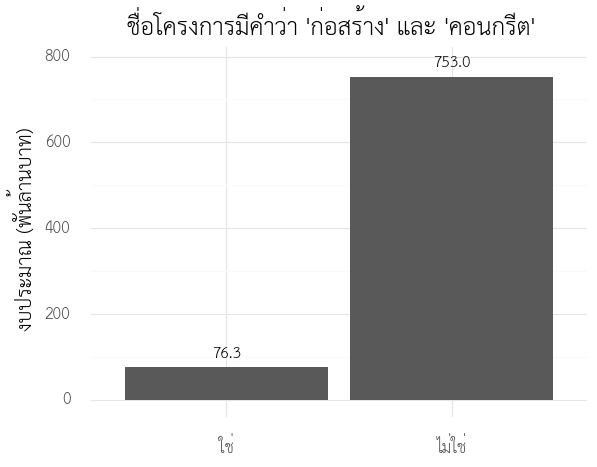

<ggplot: (-9223363249662534975)>

In [260]:
g = (ggplot(bbm, aes(x='constructions',y='sum')) + geom_col() +
     xlab('') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='constructions',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ก่อสร้าง' และ 'คอนกรีต'"))
g

In [283]:
bbm = pd.DataFrame(thaime.groupby('roads').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,roads,sum,len
0,ไม่ใช่,759.017355,19806.0
1,ใช่,70.345065,13910.0


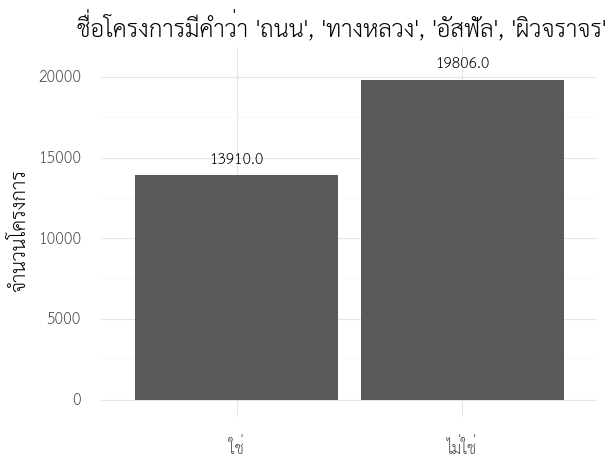

<ggplot: (-9223363249636805418)>

In [285]:
g = (ggplot(bbm, aes(x='roads',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='roads',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ถนน', 'ทางหลวง', 'อัสฟัล', 'ผิวจราจร'"))
g

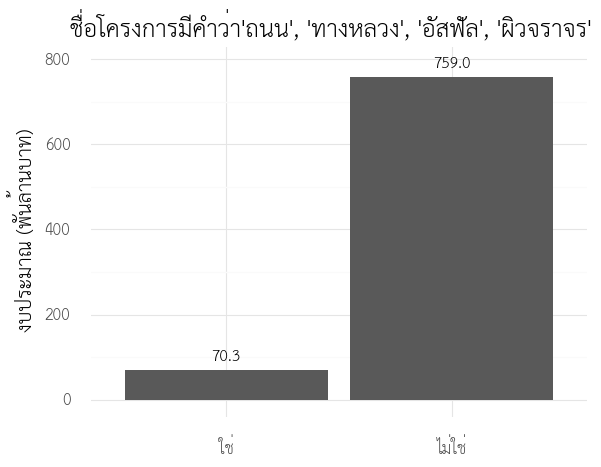

<ggplot: (8787218149331)>

In [263]:
g = (ggplot(bbm, aes(x='roads',y='sum')) + geom_col() +
     xlab('') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='roads',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ถนน', 'ทางหลวง', 'อัสฟัล', 'ผิวจราจร'"))
g

In [264]:
bbm = pd.DataFrame(thaime.groupby('canels').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,canels,sum,len
0,ไม่ใช่,807.235033,28836.0
1,ใช่,22.127387,4880.0


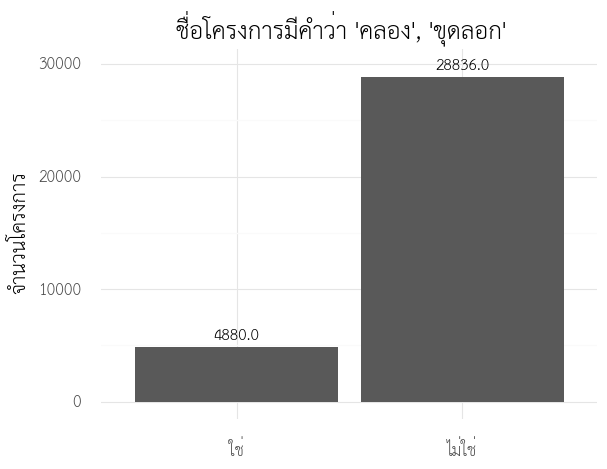

<ggplot: (8787192608078)>

In [266]:
g = (ggplot(bbm, aes(x='canels',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='canels',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'คลอง', 'ขุดลอก'"))
g

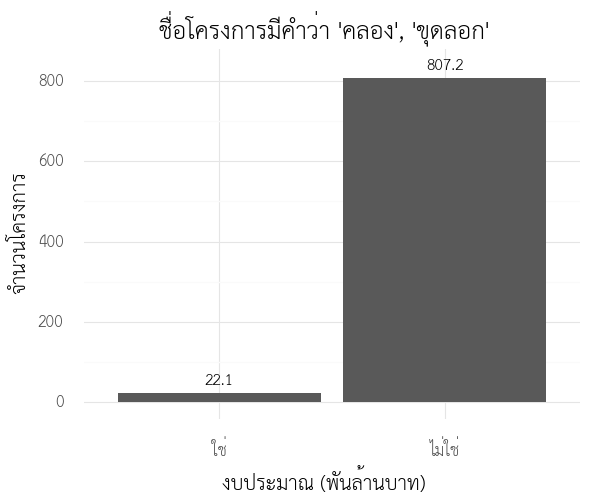

<ggplot: (8787192456603)>

In [268]:
g = (ggplot(bbm, aes(x='canels',y='sum')) + geom_col() +
     xlab('งบประมาณ (พันล้านบาท)') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='canels',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'คลอง', 'ขุดลอก'"))
g